[Kaggle Notebook Link](https://www.kaggle.com/code/alphapii/assignment-1-cvpr)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import tqdm
import tarfile
import zipfile
import requests
import time
import pickle
import platform
import matplotlib.pyplot as plt

data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# initialize the amount of data you want to take among `50K` tring data and `10k` tesing data
trainDataSize = 10000
testDataSize = 1000

In [4]:
class Downloder():
    def __init__(self):
        pass
    
    def __download_file(self,url, directory):
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress = tqdm.tqdm(total=total_size, unit='B', unit_scale=True)
        file_name = url.split("/")[-1]
        path = os.path.join(directory, file_name)

        with open(path, "wb") as f:
            for data in response.iter_content(block_size):
                progress.update(len(data))
                f.write(data)
        progress.close()
    
    def download_and_extract(self,url, download_dir):
        """
        Download and extract the data if it doesn't already exist.
        :param download_dir: Directory where the downloaded file is saved.
            Example: "data/CIFAR-10/"
        """
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)

        if not os.path.exists(file_path):
            self.__download_file(url,download_dir)
            print()
            print("Download finished. Extracting files.")

            if file_path.endswith(".zip"):
                # Unpack the zip-file.
                zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
            elif file_path.endswith((".tar.gz", ".tgz")):
                # Unpack the tar-ball.
                tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

            print("Extraction is Done.")
        else:
            print("Data has apparently already been downloaded and unpacked.")

In [5]:
class Cifar10Loader():
    def __init__(self):
        pass
    
    def __LoadBinary(self,f):
        """
        This function check the python version, that required python version 3 or above.
        If so then it will load each file with latin-1 encoder.
        
        'https://stackoverflow.com/questions/4299802/python-convert-string-from-utf-8-to-latin-1'
        """
        ver = platform.python_version_tuple()
        if ver[0]=='3':
            return pickle.load(f, encoding='latin1')
        else :
            return ValueError("invalid python version: {}".format(version))
        
    def __loadCifarBatchs(self, filename):
        """
        Function for loading the loading the eatch batch of the Cifar-10 Dataset.
        """
        with open(filename,'rb') as f:
            data = self.__LoadBinary(f)
            x = data['data']
            y = data['labels']
            x = x.reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
            y = np.array(y)
            return x,y
        
    def load_cifar10(self, rootdir):
        """
        Finction loading the full dataset with the help of above two helper function. And Return 
        the four tupple (X_trin, y_train, X_test, y_test)
        """
        indipendent = []
        dependent = []

        for b in range(1,6):
            F = os.path.join(rootdir,'data_batch_%d'%(b,))
            X , Y = self.__loadCifarBatchs(F)
            indipendent.append(X)
            dependent.append(Y)
        xtrain = np.concatenate(indipendent)
        ytrian = np.concatenate(dependent)
        del indipendent, dependent
        xtest, ytest = self.__loadCifarBatchs(os.path.join(rootdir,'test_batch'))
        
        return xtrain, ytrian, xtest, ytest

# Nearest Neighbour Calss

In [6]:
class NearestNeighbourClassifier():
    
    def __init__(self,k,train = 10000,test = 1000):
        self.k = k
        self.traing_size = train
        self.test_size = test
    
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y
        
    def claculate_distance(self,X):
            dists = np.zeros((self.test_size, self.traing_size)) 
            dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
            pass
            return dists
    
    def predict(self,X):
        """
        Function takes test numpy-n-array as input and calculate
        the distance beteween test image and train images. 
        Based on that distance the predicted lable is computed.
        """
        dist = self.claculate_distance(X)
        return self.__predict_labels(dist)

    def __predict_labels(self,dist):
        n_test = dist.shape[0]
        y_pred = np.zeros(n_test)
        
        for i in range(n_test):
            closest = []
            sorted_dist = np.argsort(dist[i])
            closest = list(self.y_train[sorted_dist[0: self.k]])
            y_pred[i] = np.argmax(np.bincount(closest))
            
        return y_pred
    def ClassificationResult(self, pred, y_test):
        """
        Return the value of correctly classified number and the accuracy of the classifier
        """
        correct = np.sum(pred == y_test)
        accuracy = float(correct) / y_test.shape[0]

        return correct, accuracy

In [7]:
# !rm "cifar-10-python.tar.gz"
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
download_dir = "D:/cifar-10-batches-py"
downloder = Downloder()
downloder.download_and_extract(data_url, download_dir)


Download finished. Extracting files.
Extraction is Done.


In [8]:
!ls

__notebook_source__.ipynb  cifar-10-batches-py	cifar-10-python.tar.gz


In [11]:
loader = Cifar10Loader()
cifar10_dir = "D:/cifar-10-batches-py"
X_train, y_train, X_test, y_test = loader.load_cifar10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [12]:
def visualizSampleData(classess, number):

    for lbl, cls in enumerate(classess):
        idxs = np.flatnonzero(y_train == lbl)
        idxs = np.random.choice(idxs, number, replace = False)

        for i, j in enumerate(idxs):
            plt_idx = i * len(classess) + lbl + 1
            plt.subplot(number, len(classess), plt_idx)
            plt.imshow(X_train[j].astype('uint8'))
            plt.axis('off')
            
            if i == 0:
                plt.title(cls)   
    plt.show()

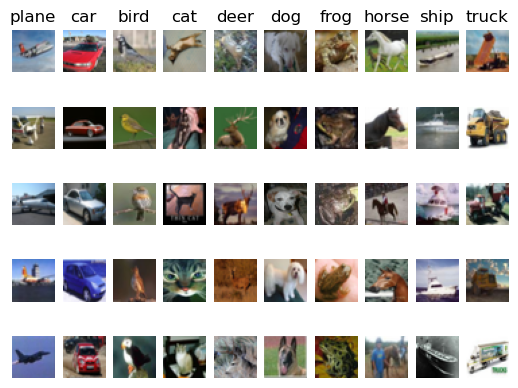

In [14]:
visualizSampleData(classess= classes, number=5)

In [15]:
def dataSubsampler(X_train, y_train, X_test, y_test, trainSize = 10000, testSize = 1000):
    """
    Resize the train and test size as define the size. Takes the six perameter with two difault parameters.
    """
    if trainSize > X_train.shape[0] or testSize > X_test.shape[0]:
        raise ValueError('Invalid value of Training size of Test size')
        
    X_train = X_train[list(range(trainSize))]
    y_train = y_train[list(range(trainSize))]
    
    X_test = X_test[list(range(testSize))]
    y_test = y_test[list(range(testSize))]
    
    return X_train, y_train, X_test, y_test

In [16]:
X_train, y_train, X_test, y_test = dataSubsampler(X_train, y_train, X_test, y_test,trainDataSize, testDataSize)

In [17]:
# Changing the shape of the data

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_train.shape, X_test.shape

((10000, 3072), (1000, 3072))

# KNN

In [18]:
%%time
classifier = NearestNeighbourClassifier(5,trainDataSize,testDataSize)
classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

correct, accuracy = classifier.ClassificationResult(pred, y_test)
print('From %d over %d image is correct.\nAccuracy: %f' % (correct, X_test.shape[0], accuracy))

From 296 over 1000 image is correct.
Accuracy: 0.296000
Wall time: 2.58 s


In [19]:
def plot_Accuracies(fold,k_choices,accuracies):
    best = [0,0]
    for k in k_choices:
        accu = accuracies[k]
        if best[1]< max(accu):
            best[0]=k; best[1]=max(accu)
        plt.scatter([k] * len(accu), accu)

    # plot the trend line with error bars that correspond to standard deviation

    accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
    accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
    plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
    plt.title(f"Cross-validation on fold={fold} with best K={best[0]} Accuracy = {best[1]}")
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.show()

# Cross Validation

Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 28.850000
k = 1, accuracy = 28.400000
k = 1, accuracy = 28.250000
k = 1, accuracy = 27.450000
k = 1, accuracy = 27.700000
k = 3, accuracy = 28.750000
k = 3, accuracy = 27.400000
k = 3, accuracy = 27.850000
k = 3, accuracy = 26.750000
k = 3, accuracy = 26.550000
k = 5, accuracy = 29.450000
k = 5, accuracy = 28.400000
k = 5, accuracy = 29.750000
k = 5, accuracy = 27.500000
k = 5, accuracy = 27.850000
k = 8, accuracy = 29.850000
k = 8, accuracy = 29.600000
k = 8, accuracy = 28.400000
k = 8, accuracy = 27.400000
k = 8, accuracy = 28.600000
k = 10, accuracy = 30.250000
k = 10, accuracy = 28.700000
k = 10, accuracy = 28.400000
k = 10, accuracy = 26.600000
k = 10, accuracy = 28.500000
k = 12, accuracy = 30.450000
k = 12, accuracy = 29.350000
k = 12, accuracy = 28.550000
k = 12, accuracy = 26.500000
k = 12, accuracy = 27.550000
k = 15, accuracy = 29.400000
k = 15, accuracy = 29.700000
k = 15, accuracy = 27.500000
k = 15

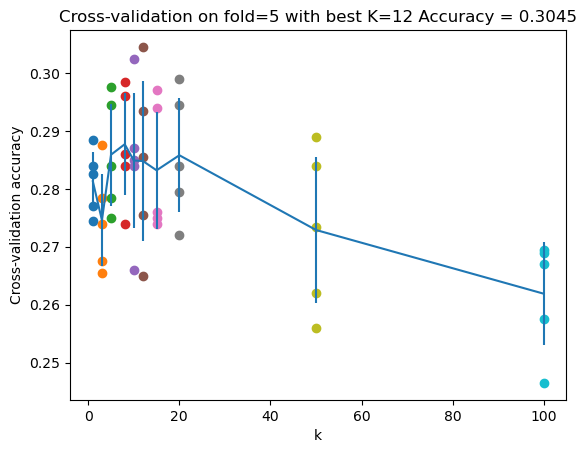

Wall time: 4min 3s


In [20]:
%%time

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
traning_size = trainDataSize
test_size = testDataSize

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
accuracies = {}

for k in k_choices:
    accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = NearestNeighbourClassifier(k)
        classifier.fit(X_train, y_train)
        
        y_test_pred = classifier.predict(X_test)
        
        correct, accuracy = classifier.ClassificationResult(y_test_pred, y_test)
        
        accuracies[k].append(accuracy)

print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(accuracies):
    for accuracy in accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy*100))

plot_Accuracies(num_folds,k_choices,accuracies)

# Cross Validation with list of folds and k-choices

In [21]:
def KNN(num_folds, k_choices, X, y, traning_size=10000, test_size=1000):
    accuracies = {}

    if (num_folds is not None) and type(num_folds) is not list:
        X_train_folds = []
        y_train_folds = []

        X_train_folds = np.array_split(X, num_folds)
        y_train_folds = np.array_split(y, num_folds)

        for k in k_choices:
            accuracies[k] = []
            for num_knn in range(0, num_folds):
                X_test = X_train_folds[num_knn]
                y_test = y_train_folds[num_knn]
                X_train = X_train_folds
                y_train = y_train_folds

                temp = np.delete(X_train, num_knn, 0)
                X_train = np.concatenate((temp), axis=0)
                y_train = np.delete(y_train, num_knn, 0)
                y_train = np.concatenate((y_train), axis=0)

                classifier = NearestNeighbourClassifier(k)
                classifier.fit(X_train, y_train)

                y_test_pred = classifier.predict(X_test)

                correct, accuracy = classifier.ClassificationResult(y_test_pred, y_test)

                accuracies[k].append(accuracy)
        plot_Accuracies(num_folds,k_choices, accuracies)

    elif (num_folds is not None) and (type(num_folds) is list):
        for fold in num_folds:
            X_train_folds = []
            y_train_folds = []
            X_train_folds = np.array_split(X, fold)
            y_train_folds = np.array_split(y, fold)

            for k in k_choices:
                accuracies[k] = []
                for num_knn in range(0, fold):
                    X_test = X_train_folds[num_knn]
                    y_test = y_train_folds[num_knn]
                    X_train = X_train_folds
                    y_train = y_train_folds

                    temp = np.delete(X_train, num_knn, 0)
                    X_train = np.concatenate((temp), axis=0)
                    y_train = np.delete(y_train, num_knn, 0)
                    y_train = np.concatenate((y_train), axis=0)

                    classifier = NearestNeighbourClassifier(k)
                    classifier.fit(X_train, y_train)

                    y_test_pred = classifier.predict(X_test)

                    correct, accuracy = classifier.ClassificationResult(y_test_pred, y_test)

                    accuracies[k].append(accuracy)
            # Ploting the Acccuracy of the current fold.
            plot_Accuracies(fold,k_choices, accuracies)


c:\Users\Next_IT_Admin\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


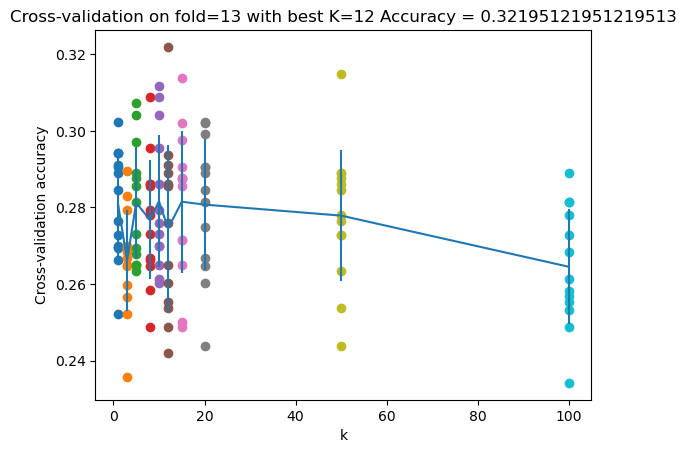

Wall time: 2min 35s


In [22]:
%%time

KNN(num_folds=13, k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100], X=X_train, y=y_train,traning_size=trainDataSize, test_size=testDataSize)

In [3]:
%%time

KNN(num_folds=[3,5,7,10], k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100], X=X_train, y=y_train,traning_size=trainDataSize, test_size=testDataSize)

NameError: name 'KNN' is not defined

## Refernces

+ https://ryli.design/blog/knn#introduction
+ https://ljvmiranda921.github.io/notebook/2017/02/09/k-nearest-neighbors/